# <u><b>AI Detection: Predicts AI involvement in text</u></b>
#### <b>Team Name</b>: Birds aren't Real
#### <b>Group Members</b>: Avery Gilbert, Jamie Ordonez, Sreedhar Shivapuram

## Introduction & Objective
---

AI-generated content is becoming more common, making it harder to tell if a text was written by a person or created by a machine. This project focuses on creating a model to determine whether a text, like an essay, is human-written or AI-generated. The goal is to help educators, journalists, and others who need to verify the authenticity of written content. Using the "LLM-Detect AI Generated Text" dataset from Kaggle, we applied machine learning methods to classify the source of the text.


## Dataset Overview
---

We utilized the "LLM-Detect AI Generated Text" dataset from Kaggle, comprising over 28,000 essays labeled as either human-generated (0) or AI-generated (1)
</br></br>
The dataset’s licensing under Apache 2.0 facilitated its use for this academic project.

## Dataset Analysis
---

In [1]:
!pip install --upgrade tensorflow --quiet
!pip install keras-nlp --quiet
!pip install tensorflow-text --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 846.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 84.0 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import keras_nlp
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import random

Num GPUs Available:  1


In [3]:
# 0 = Human, 1 = AI
df = pd.read_csv("Training_Essay_Data.csv")
df.head()

,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


In [ ]:
# Split into 2 datasets. human generated and AI generated for analysis
human_df = df[df['generated'] == 0]
ai_df = df[df['generated'] == 1]

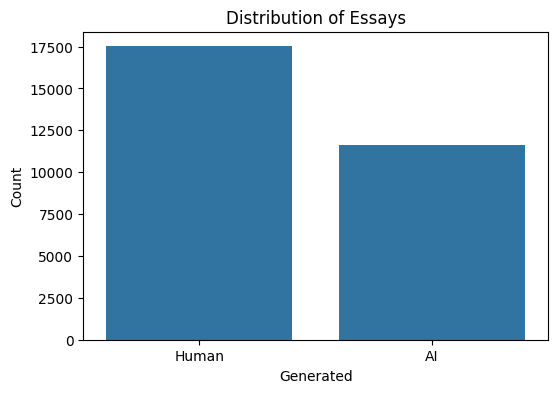

In [ ]:
# Visualizations
# Distribution of essay counts
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='generated')
plt.title('Distribution of Essays')
plt.xticks([0, 1], ['Human', 'AI'])
plt.xlabel('Generated')
plt.ylabel('Count')
plt.show()

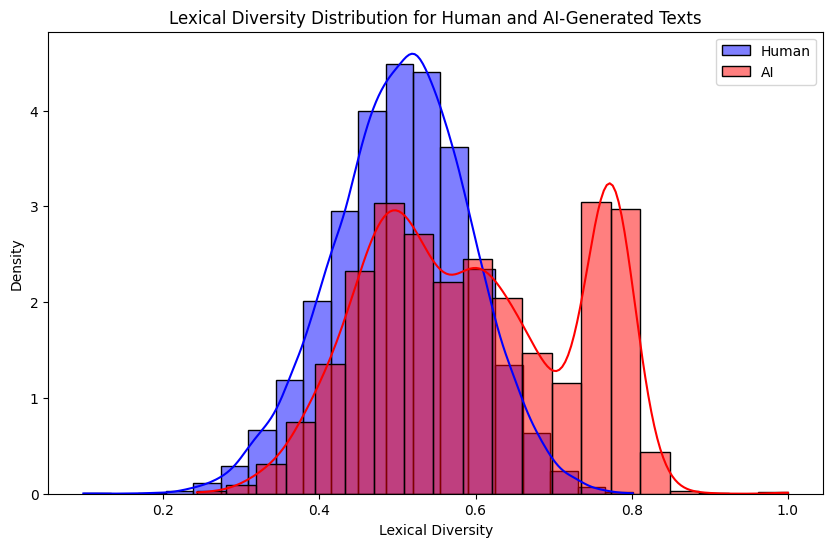

In [ ]:
# Measure the diversity of words used in human vs. AI-generated texts:
human_lexical_diversity = human_df['text'].apply(lambda x: len(set(x.split())) / len(x.split()))
ai_lexical_diversity = ai_df['text'].apply(lambda x: len(set(x.split())) / len(x.split()))

# Create a DataFrame to hold the values for plotting
lexical_diversity_df = pd.DataFrame({
    'Lexical Diversity': pd.concat([human_lexical_diversity, ai_lexical_diversity]),
    'Type': ['Human'] * len(human_lexical_diversity) + ['AI'] * len(ai_lexical_diversity)
})

# Plot the data
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='Type', y='Lexical Diversity', data=lexical_diversity_df, palette='Set2')
# plt.title('Lexical Diversity Distribution for Human and AI-Generated Texts')
# plt.xlabel('Type of Text')
# plt.ylabel('Lexical Diversity')
# plt.show()
plt.figure(figsize=(10, 6))
sns.histplot(human_lexical_diversity, kde=True, color='blue', label='Human', bins=20, stat='density')
sns.histplot(ai_lexical_diversity, kde=True, color='red', label='AI', bins=20, stat='density')
plt.title('Lexical Diversity Distribution for Human and AI-Generated Texts')
plt.xlabel('Lexical Diversity')
plt.ylabel('Density')
plt.legend()
plt.show()

X represents Lexical diversity scores and y represents the density/frequency of texts with a given diversity score. </br></br>
Based on this graph, human texts typically have a lower lexical diversity value compared to AI texts, meaning the human generated texts have less variety in their vocabulary. This also indicates that the AI texts typically have a higher variety in their vocabulary.

In [ ]:
import nltk
nltk.download('punkt')  # For tokenization
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')  # For POS tagging
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [ ]:
def pos_analysis(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens, tagset='universal')
    return [tag for _, tag in tags]

human_df.loc[:, 'pos_tags'] = human_df['text'].apply(pos_analysis)
ai_df.loc[:, 'pos_tags'] = ai_df['text'].apply(pos_analysis)

<ipython-input-23-7164cc328e4c>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_pos_df_top10['Source'] = 'Human'
<ipython-input-23-7164cc328e4c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_pos_df_top10['Source'] = 'AI'


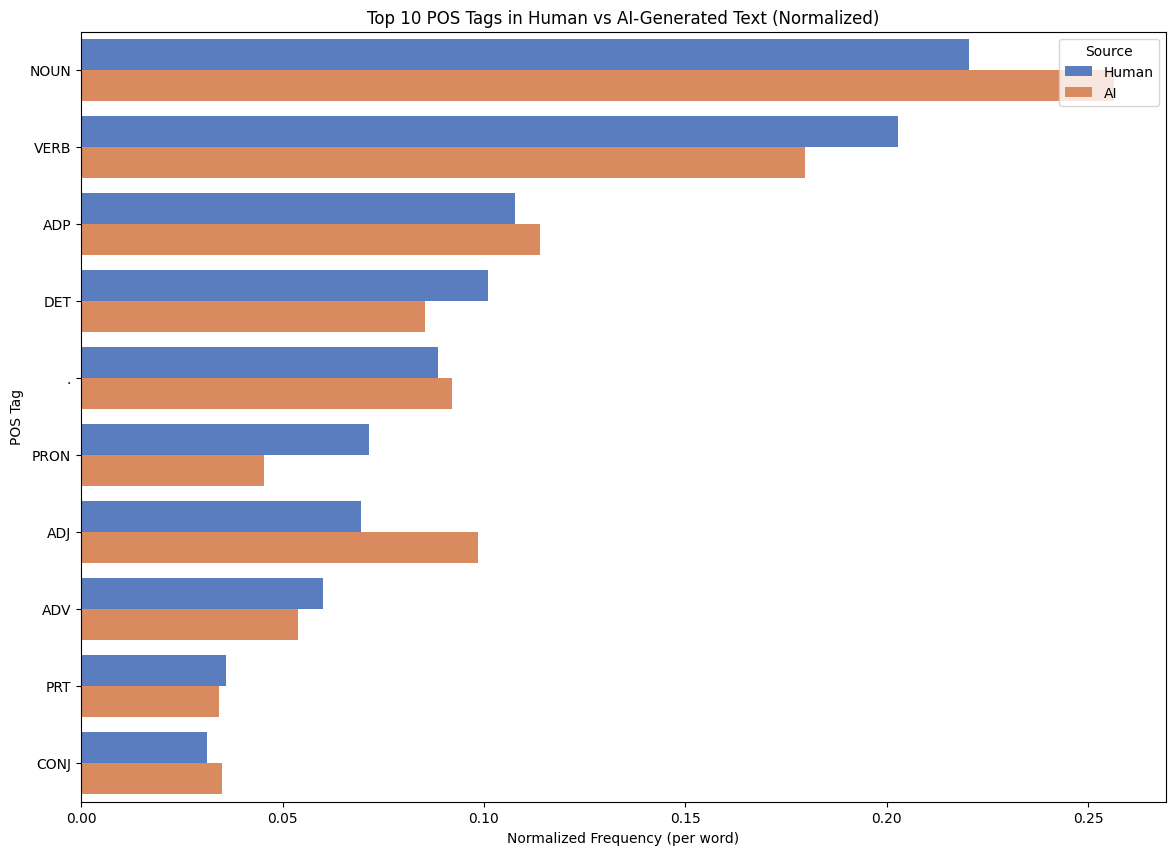

In [ ]:
# Convert the POS tag lists to strings for easier counting
human_pos_tags = human_df['pos_tags'].apply(lambda x: ' '.join(x))
ai_pos_tags = ai_df['pos_tags'].apply(lambda x: ' '.join(x))

# Get the frequency count of POS tags in both datasets
human_pos_count = Counter(' '.join(human_pos_tags).split())
ai_pos_count = Counter(' '.join(ai_pos_tags).split())

# Calculate total word counts
human_word_count = human_pos_tags.str.split().str.len().sum()
ai_word_count = ai_pos_tags.str.split().str.len().sum()

# Convert to DataFrame for better visualization
human_pos_df = pd.DataFrame(human_pos_count.items(), columns=['POS Tag', 'Frequency']).sort_values(by='Frequency', ascending=False)
ai_pos_df = pd.DataFrame(ai_pos_count.items(), columns=['POS Tag', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Normalize the frequencies
human_pos_df['Normalized Frequency'] = human_pos_df['Frequency'] / human_word_count
ai_pos_df['Normalized Frequency'] = ai_pos_df['Frequency'] / ai_word_count

# Keep only the top 10 POS tags
human_pos_df_top10 = human_pos_df.head(10)
ai_pos_df_top10 = ai_pos_df.head(10)

# Add a column to indicate whether the data is for human or AI
human_pos_df_top10['Source'] = 'Human'
ai_pos_df_top10['Source'] = 'AI'

# Concatenate the human and AI dataframes
combined_pos_df = pd.concat([human_pos_df_top10, ai_pos_df_top10])

# Plot the combined POS Tag Frequency
plt.figure(figsize=(14, 10))
sns.barplot(x='Normalized Frequency', y='POS Tag', hue='Source', data=combined_pos_df, palette='muted')
plt.title('Top 10 POS Tags in Human vs AI-Generated Text (Normalized)')
plt.xlabel('Normalized Frequency (per word)')
plt.ylabel('POS Tag')
plt.legend(title='Source', loc='upper right')
plt.show()

Based on this graph on frequency of parts of speech the AI texts appear to utilize more more nouns, and significantly more adjectives than Human texts. Where Human texts tend to use more verbs and significantly more pronouns than AI texts.

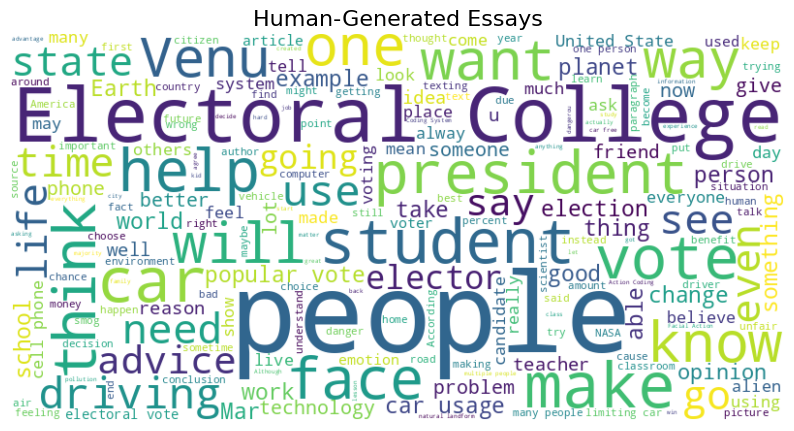

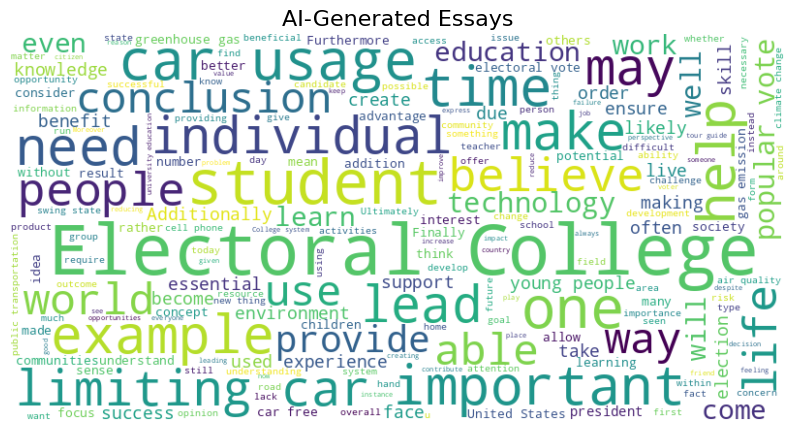

In [ ]:
# Word Clouds
def generate_wordcloud(text_data, title):
    text = " ".join(text_data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Human-generated word cloud
if not human_df.empty:
    generate_wordcloud(human_df['text'], "Human-Generated Essays")

# AI-generated word cloud
if not ai_df.empty:
    generate_wordcloud(ai_df['text'], "AI-Generated Essays")

Frequent Phrases in Human-Generated Content:
                    Phrase  Count
0        electoral college     69
1            better choice     22
2             popular vote     22
3                car usage     18
4              make better     18
5       make better choice     16
6         natural landform     15
7                help make     14
8         help make better     13
9  help make better choice     12


<ipython-input-12-5e34e6964e4a>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=human_patterns, x='Count', y='Phrase', palette='viridis')


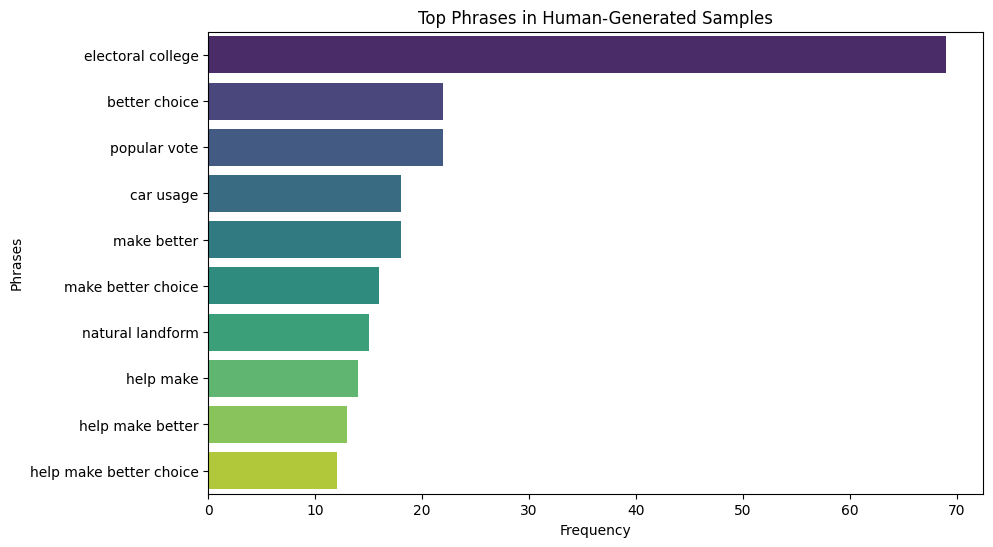

Frequent Phrases in AI-Generated Content:
                     Phrase  Count
0         electoral college     43
1                 car usage     28
2              limiting car     21
3        limiting car usage     21
4             gas emissions     12
5            greenhouse gas     12
6  greenhouse gas emissions     12
7              popular vote     12
8              written word     12
9                  cars use      9


<ipython-input-12-5e34e6964e4a>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ai_patterns, x='Count', y='Phrase', palette='magma')


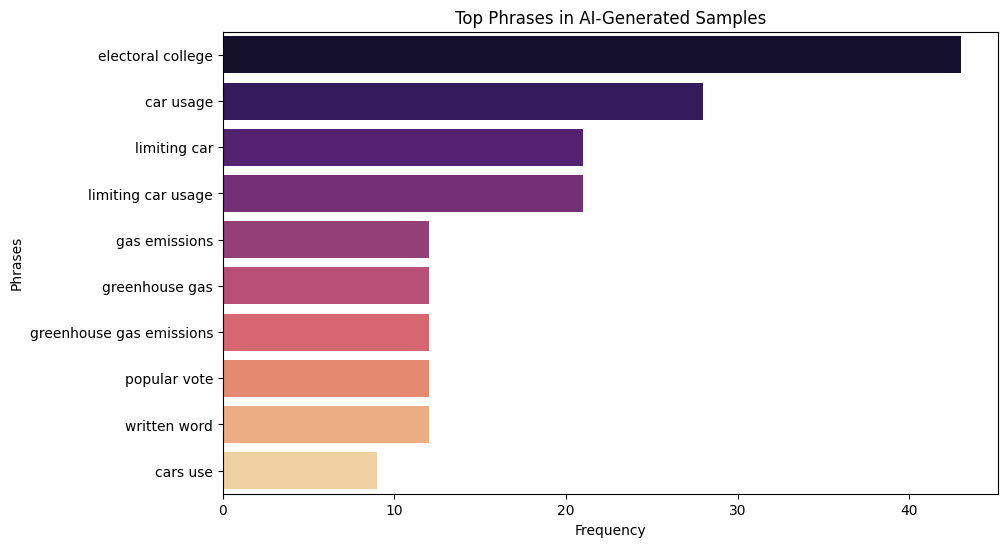

In [ ]:
# Function to sample random examples
def sample_random_examples(dataframe, n=50):
    return dataframe.sample(n=min(len(dataframe), n), random_state=42)

# Function to find meaningful patterns
def analyze_word_patterns(data, ngram_range=(2, 5), top_n=10):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(data)
    phrases = vectorizer.get_feature_names_out()
    phrase_counts = X.sum(axis=0).A1
    phrase_freq = list(zip(phrases, phrase_counts))
    sorted_phrases = sorted(phrase_freq, key=lambda x: x[1], reverse=True)[:top_n]
    return pd.DataFrame(sorted_phrases, columns=['Phrase', 'Count'])

# Random sampling
human_sample = sample_random_examples(human_df, 50)
ai_sample = sample_random_examples(ai_df, 50)

# Analyze word patterns in human-generated content
if not human_sample.empty:
    human_patterns = analyze_word_patterns(human_sample['text'], ngram_range=(2, 8), top_n=10)
    print("Frequent Phrases in Human-Generated Content:")
    print(human_patterns)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=human_patterns, x='Count', y='Phrase', palette='viridis')
    plt.title('Top Phrases in Human-Generated Samples')
    plt.xlabel('Frequency')
    plt.ylabel('Phrases')
    plt.show()

# Analyze word patterns in AI-generated content
if not ai_sample.empty:
    ai_patterns = analyze_word_patterns(ai_sample['text'], ngram_range=(2, 8), top_n=10)
    print("Frequent Phrases in AI-Generated Content:")
    print(ai_patterns)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=ai_patterns, x='Count', y='Phrase', palette='magma')
    plt.title('Top Phrases in AI-Generated Samples')
    plt.xlabel('Frequency')
    plt.ylabel('Phrases')
    plt.show()

## Feature Engineering
---

In [4]:
# Define a function to normalize text
def normalize_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

# Apply normalization to the 'text' column
df['text'] = df['text'].apply(normalize_text)

# Display the first few rows to verify
df.head()

,text,generated
0,carfree cities have become a subject of increa...,1
1,car free cities carfree cities a concept gain...,1
2,a sustainable urban future carfree cities a...,1
3,pioneering sustainable urban living in an e...,1
4,the path to sustainable urban living in an ...,1


In [5]:
# Split train and test data (80% of the original data is for training, the rest for validation+test data)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["generated"])

# Second split: Split the test set into validation and test sets (10% of the original data is for validation, 10% is for testing)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df["generated"])

# Separate texts and labels for train, validation, and test
x_train_raw = train_df["text"]
y_train_raw = train_df["generated"]

x_val_raw = val_df["text"]
y_val_raw = val_df["generated"]

x_test_raw = test_df["text"]
y_test_raw = test_df["generated"]

In [6]:
from sklearn.preprocessing import LabelEncoder

# Convert labels to one-hot encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train_raw)
y_test = encoder.transform(y_test_raw)

generation_names = encoder.classes_
print ("Order of the generation in the 1 hot encodings\n", generation_names)

# print a few values
print(x_train_raw[:5])
print(y_train[:5])

Order of the generation in the 1 hot encodings
 [0 1]
8311     in this essay i will talk about if the use of ...
26382    the importance of selfcare should never be und...
10684    do you think this face was created by aliens i...
20102    \nthe potential impact of the use of social me...
16282    many people believe that selfesteem comes from...
Name: text, dtype: object
[0 1 0 1 0]


## Model 1 Pre-trained BERT model
---

In [7]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_base_en_uncased",
    num_classes= len(generation_names)
)
classifier.backbone.trainable = False

classifier.backbone.summary()

100%|██████████| 510/510 [00:00<00:00, 1.03MB/s]


100%|██████████| 418M/418M [00:12<00:00, 34.9MB/s]


100%|██████████| 547/547 [00:00<00:00, 532kB/s]


100%|██████████| 226k/226k [00:00<00:00, 1.04MB/s]


Model: "bert_backbone"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ token_ids (InputLayer)    │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_embedding           │ (None, None, 768)      │     23,440,896 │ token_ids[0][0]        │
│ (ReversibleEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_ids (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ position_embedding        │ (None, None, 768)      │        393,216 │ token_embedding[0][0]  │
│ (PositionEmbedding)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ segment_embedding         │ (None, None, 768)      │          1,536 │ segment_ids[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embeddings_add (Add)      │ (None, None, 768)      │              0 │ token_embedding[0][0], │
│                           │                        │                │ position_embedding[0]… │
│                           │                        │                │ segment_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embeddings_layer_norm     │ (None, None, 768)      │          1,536 │ embeddings_add[0][0]   │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embeddings_dropout        │ (None, None, 768)      │              0 │ embeddings_layer_norm… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ padding_mask (InputLayer) │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_layer_0       │ (None, None, 768)      │      7,087,872 │ embeddings_dropout[0]… │
│ (TransformerEncoder)      │                        │                │ padding_mask[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_layer_1       │ (None, None, 768)      │      7,087,872 │ transformer_layer_0[0… │
│ (TransformerEncoder)      │                        │                │ padding_mask[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_layer_2       │ (None, None, 768)      │      7,087,872 │ transformer_layer_1[0… │
│ (TransformerEncoder)      │                        │                │ padding_mask[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_layer_3       │ (None, None, 768)      │      7,087,872 │ transformer_layer_2[0… │
│ (TransformerEncoder)      │                        │                │ padding_mask[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_layer_4       │ (None, None, 768)      │      7,087,872 │ transformer_layer_3[0… │
│ (TransformerEncoder) 

 Total params: 109,482,240 (417.64 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 109,482,240 (417.64 MB)

In [8]:
#implement adam optimizer
import keras
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(5e-5),
    jit_compile=True,
)

In [ ]:
# Train Model
# Create a tf.data.Dataset for efficient data loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw.tolist(), y_train))
train_dataset = train_dataset.batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# classifier.fit(x_train_raw.tolist(), y_train, epochs=10, batch_size=64)
classifier.fit(train_dataset, epochs=10)

In [10]:
test_loss, test_acc = classifier.evaluate(x_test_raw, y_test)
print("Test Accuracy:", test_acc)

92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 911ms/step - loss: 0.1956 - sparse_categorical_accuracy: 0.9231
Test Accuracy: 0.9272727370262146


In [ ]:
# Save the trained model
classifier.save("BERT_AI_detection_model_normalized.keras")

In [ ]:
# Download the model
from google.colab import files
files.download('BERT_AI_detection_model_normalized.keras')

In [9]:
# Load the saved model
classifier = tf.keras.models.load_model("BERT_AI_detection_model_normalized.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Run a classification report on the trained model

In [11]:
from sklearn.metrics import classification_report
# Predict the class probabilities for the test set
y_pred_prob = classifier.predict(x_test_raw, batch_size=32)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_prob, axis=1)

print(y_pred)
# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 966ms/step
[0 1 1 ... 1 0 0]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94      1751
           1       0.87      0.97      0.91      1164

    accuracy                           0.93      2915
   macro avg       0.92      0.93      0.93      2915
weighted avg       0.93      0.93      0.93      2915



Perform Roc Curve to determine the best threshold

92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 926ms/step
AUC Score: 0.9879960591983765


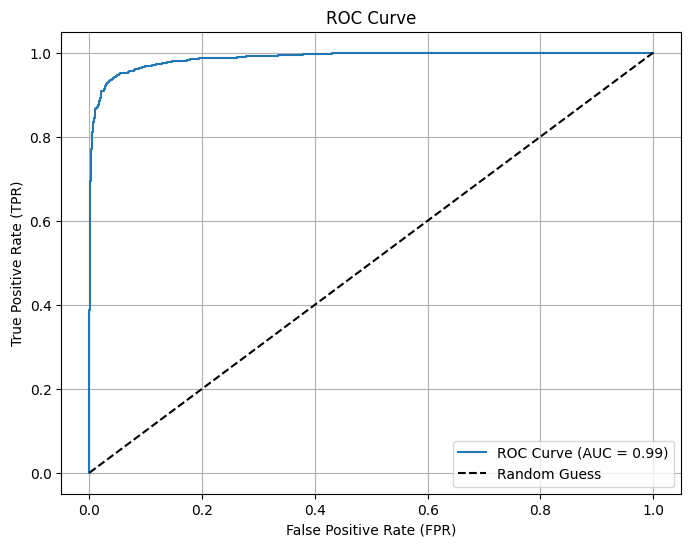

Best Threshold: 0.50801516


In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
# Predict probabilities for the positive class (AI Generated)
y_pred_prob = classifier.predict(x_test_raw, batch_size=32)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Compute the AUC
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC Score:", auc_score)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

# Find the best threshold
youden_index = tpr - fpr
best_threshold = thresholds[np.argmax(youden_index)]
print("Best Threshold:", best_threshold)

The ROC Curve, indicated by the blue line, shows that the model predicts whether a given text is AI or human generated much more accurately than a random guess would. The AUC of 0.987 indicates the model has a 98.7% probability of correctly classifying a text.</br></br>
The best Threshold indicated from this curve is .508

## Model 1 Analysis
---

Testing with a human-written examples

In [14]:
from scipy.special import softmax
import string
avery_test = [
    "Here I am testing to determine if the model we trained will figure out if this is human generated or AI generated. I am writing a few sentences and lines to test if the model will pick up on anything. The model wasn't trained on this data and hasn't seen it before. I will give it a few more lines before I swap over to a new topic and try passing in some AI generated content.",
    "This is another test regarding the fact that birds aren't real. If birds were real you would have seen one in public, but really when was the last time you actuall saw a bird? The only thing that birds are able to do is spy because they are government operators and are cameras for the FBI.",
    "Miguel León-Portilla's 'General Introduction' outlines the rich cultural, intellectual, and religious life of Mesoamerican civilizations, emphasizing their achievements and sophistication. He discusses how these civilizations developed complex social structures, advanced knowledge in astronomy and mathematics, and created intricate art and architecture. León-Portilla challenges Eurocentric perspectives, highlighting the importance of understanding these cultures on their own terms.",
    "The project requires us to analyze our chosen dilemma by analyzing the parties involved, the impact, and its role in health informatics. Afterwards, each of us plans to examine the dilemma in conjunction with one of the iSchool’s four core values through an individual essay. Individually, we will explore the realm of health informatics, various perspectives in our dilemma, our chosen core value, and possible solutions. We will peer review our essays and create a group paper with a pitch synthesizing a course of action based on our solutions.",
    "Here are some general instructions for preparing the project report: Introduction: Begin your report with an introduction that includes a brief overview of the problem you were trying to solve, the data you used, and the methods you employed. Data Description: Describe the dataset you used, where it came from, and how you pre-processed it. Include information about any data cleaning, transformation, or feature engineering you did. Methodology: Discuss the methods you used to analyze the data and solve the problem. This may include machine learning algorithms, statistical analysis, or other techniques. Be sure to include the rationale for why you chose each method and any assumptions or limitations associated with them. Results: Present your findings, including any visualizations, tables, or other outputs you generated. Explain the significance of your results and how they address the problem you were trying to solve. Provide an analysis of your results and explain what insights you gained from them. Conclusion: Summarize your key findings and conclusions. Consider the limitations of your approach, as well as any potential applications or future work that could build on your project. References: Include a list of any sources you used in your report, including datasets, code libraries, research papers, and other resources. Code: Include a well-documented code repository that provides sufficient instructions on how to run the code you used to conduct your analysis.Visual Aids: Include visual aids such as graphs, charts, and images to help illustrate your findings and make your report more engaging.Edit and Proofread: Make sure to edit and proofread your report carefully to ensure that it is free from errors and follows a logical flow. Submit on time: Make sure to submit your report on time according to the instructions provided by the course instructor."
    ]

for essay in avery_test:
    predicted_class = classifier.predict(x=[essay], batch_size=1)

    print(predicted_class)
    #softmax
    softmax_predictions = softmax(predicted_class, axis=1)  # Specify axis=1 for row-wise softmax

    # Find the predicted class
    predicted_class_index = np.argmax(softmax_predictions, axis=1)

    # Get the prediction score for the predicted class
    predicted_class_score = softmax_predictions[0, predicted_class_index[0]]
    print(predicted_class_score)

    # Interpret the result
    label = "AI-Generated" if predicted_class_score >= 0.5 else "Human-Written"
    print(f"The model predicts this text as: {label}")
    print(f"The predicted class is: {predicted_class_score}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
[[-0.3199843  0.5983461]]
0.71470183
The model predicts this text as: AI-Generated
The predicted class is: 0.7147018313407898
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
[[ 0.31575903 -0.10080112]]
0.6026598
The model predicts this text as: AI-Generated
The predicted class is: 0.6026598215103149
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step
[[-2.5453768  2.8273747]]
0.99538016
The model predicts this text as: AI-Generated
The predicted class is: 0.995380163192749
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
[[-3.2073166  3.456848 ]]
0.99872583
The model predicts this text as: AI-Generated
The predicted class is: 0.9987258315086365
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
[[-1.2855513  1.6812432]]
0.9510513
The model predicts this text as: AI-Generated
The predicted class is: 0.9510512948036194


Testing with an AI generated Essays

In [15]:
ai_test_essays = [
    "The invention of the wheel was a turning point in human history. It revolutionized transportation, enabling goods and people to move efficiently across long distances. From carts to modern vehicles, the wheel remains a symbol of innovation. Its simplicity and utility showcase humanity's ingenuity and problem-solving abilities.",

    "Climate change is one of the most pressing issues of our time. Rising temperatures, melting ice caps, and extreme weather events threaten ecosystems and human life. Addressing this crisis requires global cooperation and a commitment to sustainable practices. Every action counts in securing a healthier planet for future generations.",

    "Space exploration represents the pinnacle of human curiosity and ambition. From landing on the moon to exploring distant planets, it expands our understanding of the universe. Missions like those to Mars inspire hope and demonstrate the potential of science and technology. The stars are within our reach if we dare to dream.",

    "Education is the cornerstone of progress in any society. It empowers individuals, fosters innovation, and drives economic growth. Access to quality education should be a universal right, as it paves the way for a more equitable and prosperous future. By investing in education, we invest in humanity.",

    "Artificial intelligence is transforming industries across the globe. From healthcare to finance, AI enhances efficiency and opens new possibilities. However, its rapid advancement raises ethical concerns about privacy, bias, and job displacement. Striking a balance between innovation and regulation is crucial to harness AI's potential responsibly.",

    "Renewable energy is key to combating climate change and reducing dependence on fossil fuels. Solar, wind, and hydroelectric power offer sustainable alternatives that can meet global energy demands. Transitioning to renewables requires investment and political will, but the benefits for the planet and future generations are undeniable.",

    "Exercise is essential for maintaining physical and mental health. Regular activity reduces the risk of chronic diseases, boosts mood, and improves overall quality of life. Whether through sports, yoga, or a simple walk, making time for exercise is a powerful investment in personal well-being.",

    "The ocean covers more than 70% of the Earth's surface and is vital to life. It regulates the climate, provides food, and supports biodiversity. Yet, pollution and overfishing threaten its health. Protecting the ocean requires global cooperation and a shift toward sustainable practices to preserve this invaluable resource.",

    "Art is a universal language that transcends cultural and linguistic barriers. It expresses emotions, tells stories, and connects people across time and space. Whether through painting, music, or literature, art enriches our lives and offers a glimpse into the human experience. Creativity is at the heart of what makes us human.",

    "Technology has revolutionized communication, making the world more connected than ever before. Social media, video calls, and instant messaging bridge distances and foster global relationships. However, this connectivity comes with challenges such as misinformation and privacy concerns. Navigating the digital age requires critical thinking and responsible use of technology."

    "Car-free cities have become a subject of increasing interest and debate in recent years, as urban areas around the world grapple with the challenges of congestion, pollution, and limited resources. The concept of a car-free city involves creating urban environments where private automobiles are either significantly restricted or completely banned, with a focus on alternative transportation methods and sustainable urban planning. This essay explores the benefits, challenges, and potential solutions associated with the idea of car-free cities.  Benefits of Car-Free Cities  Environmental Sustainability: Car-free cities promote environmental sustainability by reducing air pollution and greenhouse gas emissions. Fewer cars on the road mean cleaner air and a significant decrease in the contribution to global warming.  Improved Public Health: A reduction in automobile usage can lead to better public health outcomes. Fewer cars on the road result in fewer accidents and a safer urban environment for pedestrians and cyclists. Moreover, less air pollution can lead to reduced respiratory and cardiovascular problems.  Efficient Use of Space: Car-free cities utilize urban space more efficiently. Parking lots and wide roads can be repurposed for green spaces, parks, and pedestrian zones, enhancing the overall quality of life in the city.  Reduced Traffic Congestion: By eliminating or restricting car usage, traffic congestion is significantly reduced, leading to faster commute times and less frustration for residents and commuters.  Cost Savings: Car ownership and maintenance can be expensive. Car-free cities allow residents to save money on vehicles, fuel, and insurance, improving their overall financial well-being.  Challenges of Car-Free Cities  Resistance to Change: Transitioning to a car-free city can face resistance from citizens, especially those who rely heavily on their cars for daily activities and commutes.  Public Transportation Infrastructure: An effective public transportation system is crucial for the success of car-free cities. Cities need to invest in and expand their public transportation networks to ensure that people have viable alternatives to cars.  Economic Impact: Businesses that rely on car-dependent customers may experience a decline in revenue in a car-free city. It's essential to address this economic impact and find ways to support affected businesses during the transition.  Urban Planning and Infrastructure: The redesign of urban areas for car-free living requires significant planning and investment in infrastructure, which can be a lengthy and complex process.  Solutions for Car-Free Cities  Expand Public Transportation: Invest in the expansion and improvement of public transportation systems to provide convenient and affordable alternatives to private cars.  Promote Active Transportation: Encourage walking and cycling by building bike lanes, pedestrian-friendly streets, and ensuring safe infrastructure for these activities.  Implement Carpooling and Ride-Sharing: Promote carpooling and ride-sharing services to reduce the number of private vehicles on the road.  Adopt Electric and Sustainable Transportation: Encourage the use of electric vehicles and promote sustainability by using renewable energy sources to power transportation.  Education and Public Awareness: Educate citizens about the benefits of a car-free city and involve them in the planning process to increase support and understanding.  Conclusion  Car-free cities represent a vision for a sustainable and healthier urban future. While the transition to a car-free city is not without challenges, the potential benefits in terms of environmental sustainability, public health, and efficient urban living make it a compelling goal. Through a combination of investment in public transportation, promotion of alternative transportation methods, and public engagement, cities can work towards a future where cars are no longer the dominant mode of transportation. Car-free cities offer a promising vision of a more sustainable and vibrant urban environment."
]
#the last essay is from the kaggle dataset
for essay in ai_test_essays:
    predicted_class = classifier.predict(x=[essay], batch_size=1)

    #softmax
    softmax_predictions = softmax(predicted_class, axis=1)  # Specify axis=1 for row-wise softmax

    # Find the predicted class
    predicted_class_index = np.argmax(softmax_predictions, axis=1)

    # Get the prediction score for the predicted class
    predicted_class_score = softmax_predictions[0, predicted_class_index[0]]
    print(predicted_class_score)

    # Interpret the result
    label = "AI-Generated" if predicted_class_score >= 0.7 else "Human-Written"
    print(f"The model predicts this text as: {label}")
    print(f"The predicted class is: {predicted_class_score}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
0.9974831
The model predicts this text as: AI-Generated
The predicted class is: 0.9974830746650696
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
0.99790585
The model predicts this text as: AI-Generated
The predicted class is: 0.9979058504104614
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
0.9966769
The model predicts this text as: AI-Generated
The predicted class is: 0.9966769218444824
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
0.999148
The model predicts this text as: AI-Generated
The predicted class is: 0.9991480112075806
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
0.99982494
The model predicts this text as: AI-Generated
The predicted class is: 0.9998249411582947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
0.999233
The model predicts this text as: AI-Generated
The predicted class is: 0.9992330074310303
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
0.9996816
The model predicts this text as: AI-Generated
The predicted class is: 0.9996815919876099
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/

## Model 2 Bidirectional LSTM
---

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, Attention, GlobalAveragePooling1D

# Tokenize the text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(x_train_raw)

# Get the total number of unique words (including the OOV token)
total_unique_words = len(tokenizer.word_index) + 1  # +1 to account for the OOV token

# Set vocab_size to total_unique_words
vocab_size = total_unique_words

# Parameters
max_length = 256  # Max sequence length
embedding_dim = 128

x_train_sequences = tokenizer.texts_to_sequences(x_train_raw)
x_val_sequences = tokenizer.texts_to_sequences(x_val_raw)
x_test_sequences = tokenizer.texts_to_sequences(x_test_raw)

# Pad sequences to ensure consistent input length
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_length, padding='post')
x_val_padded = pad_sequences(x_val_sequences, maxlen=max_length, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_length, padding='post')

In [17]:
from tensorflow.keras.regularizers import l2

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),

    # First Bidirectional LSTM layer with return_sequences=True to stack further LSTMs
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),  # Dropout after the first LSTM

    # Second Bidirectional LSTM layer without return_sequences for final output
    Bidirectional(LSTM(64)),
    Dropout(0.2),  # Dropout after the second LSTM

    # Fully connected layer
    Dense(64, activation='relu'),
    Dropout(0.2),  # Dropout before the output layer

    # Output layer for binary classification (AI or Human)
    Dense(2, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create the tf.data.Dataset for validation data
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_padded, y_val_raw))
val_dataset = val_dataset.batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Create the tf.data.Dataset for efficient loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_padded, y_train))
train_dataset = train_dataset.batch(64).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Train the model
model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[early_stopping])

Epoch 1/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.9019 - loss: 0.2760 - val_accuracy: 0.9362 - val_loss: 0.1887
Epoch 2/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.9772 - loss: 0.0731 - val_accuracy: 0.9684 - val_loss: 0.0942
Epoch 3/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.9828 - loss: 0.0530 - val_accuracy: 0.9749 - val_loss: 0.0764
Epoch 4/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.9931 - loss: 0.0216 - val_accuracy: 0.9818 - val_loss: 0.0566
Epoch 5/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9958 - loss: 0.0139 - val_accuracy: 0.9811 - val_loss: 0.0628
Epoch 6/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.9976 - loss: 0.0082 - val_accuracy: 0.9825 - val_loss: 0.0778


In [22]:
x_test_sequences = tokenizer.texts_to_sequences(x_test_raw)
x_test_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test_sequences, maxlen=max_length, padding='post')

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test_padded, y_test)
print("Test Accuracy:", test_acc)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9865 - loss: 0.0351
Test Accuracy: 0.9886792302131653


In [ ]:
# Save the trained model
model.save("LSTM_detection_model_bidirection.keras")

In [ ]:
# Download the model
from google.colab import files
files.download('LSTM_detection_model_bidirection.keras')

In [18]:
# Load the saved model
model = tf.keras.models.load_model("LSTM_detection_model_normalized.keras")

###Classification Report

In [23]:
from sklearn.metrics import classification_report
# Predict the class probabilities for the test set
y_pred_prob = model.predict(x_test_padded, batch_size=32)  # Adjust batch size as needed

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_prob, axis=1)

print(y_pred)
# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[0 1 1 ... 0 0 0]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1751
           1       0.99      0.99      0.99      1164

    accuracy                           0.99      2915
   macro avg       0.99      0.99      0.99      2915
weighted avg       0.99      0.99      0.99      2915



###ROC Curve

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
AUC Score: 0.9991502155861844


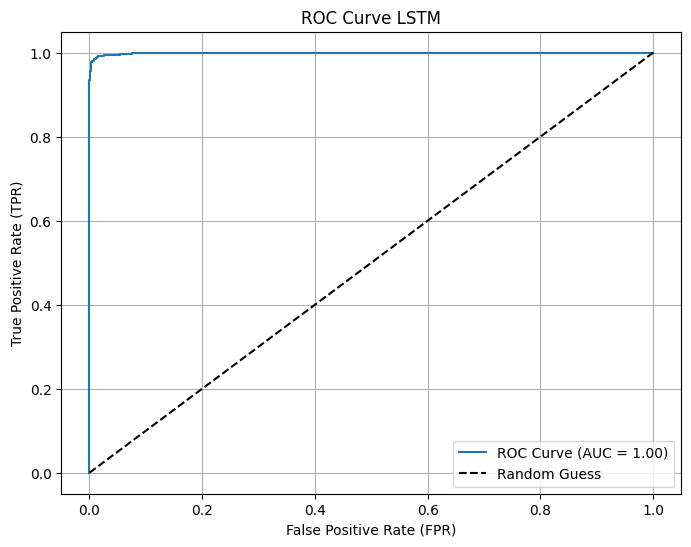

Best Threshold: 0.49475765


In [24]:
# Predict probabilities for the positive class (AI Generated)
y_pred_prob = model.predict(x_test_padded, batch_size=32)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

# Compute the AUC
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC Score:", auc_score)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve LSTM")
plt.legend(loc="best")
plt.grid()
plt.show()

# Find the best threshold
youden_index = tpr - fpr
best_threshold = thresholds[np.argmax(youden_index)]
print("Best Threshold:", best_threshold)

## Model 2 Analysis
---

In [25]:
avery_test = [
    "Here I am testing to determine if the model we trained will figure out if this is human generated or AI generated. I am writting a few sentences and lines to test if the model will pick up on anything. The model wasn't trained on this data and hasn't seen it before. I will give it a few more lines before I swap over to a new topic and try passing in some AI generated content.",
    "This is another test regarding the fact that birds aren't real. If birds were real you would have seen one in public, but really when was the last time you actuall saw a bird? The only thing that birds are able to do is spy because they are government operators and are cameras for the FBI.",
    "Miguel León-Portilla's 'General Introduction' outlines the rich cultural, intellectual, and religious life of Mesoamerican civilizations, emphasizing their achievements and sophistication. He discusses how these civilizations developed complex social structures, advanced knowledge in astronomy and mathematics, and created intricate art and architecture. León-Portilla challenges Eurocentric perspectives, highlighting the importance of understanding these cultures on their own terms.",
    "The project requires us to analyze our chosen dilemma by analyzing the parties involved, the impact, and its role in health informatics. Afterwards, each of us plans to examine the dilemma in conjunction with one of the iSchool’s four core values through an individual essay. Individually, we will explore the realm of health informatics, various perspectives in our dilemma, our chosen core value, and possible solutions. We will peer review our essays and create a group paper with a pitch synthesizing a course of action based on our solutions.",
    "Here are some general instructions for preparing the project report: Introduction: Begin your report with an introduction that includes a brief overview of the problem you were trying to solve, the data you used, and the methods you employed. Data Description: Describe the dataset you used, where it came from, and how you pre-processed it. Include information about any data cleaning, transformation, or feature engineering you did. Methodology: Discuss the methods you used to analyze the data and solve the problem. This may include machine learning algorithms, statistical analysis, or other techniques. Be sure to include the rationale for why you chose each method and any assumptions or limitations associated with them. Results: Present your findings, including any visualizations, tables, or other outputs you generated. Explain the significance of your results and how they address the problem you were trying to solve. Provide an analysis of your results and explain what insights you gained from them. Conclusion: Summarize your key findings and conclusions. Consider the limitations of your approach, as well as any potential applications or future work that could build on your project. References: Include a list of any sources you used in your report, including datasets, code libraries, research papers, and other resources. Code: Include a well-documented code repository that provides sufficient instructions on how to run the code you used to conduct your analysis.Visual Aids: Include visual aids such as graphs, charts, and images to help illustrate your findings and make your report more engaging.Edit and Proofread: Make sure to edit and proofread your report carefully to ensure that it is free from errors and follows a logical flow. Submit on time: Make sure to submit your report on time according to the instructions provided by the course instructor."
    ]

for essay in avery_test:
    # Tokenize and pad the essay
    essay_sequence = tokenizer.texts_to_sequences([essay])  # Convert the whole essay to a sequence
    essay_padded = tf.keras.preprocessing.sequence.pad_sequences(essay_sequence, maxlen=max_length, padding='post')

    # Get the prediction from the model
    predicted_class = model.predict(essay_padded, batch_size=1)

    # Apply softmax to get probabilities
    softmax_predictions = softmax(predicted_class, axis=1)

    # Determine the predicted class and its confidence
    predicted_class_index = np.argmax(softmax_predictions, axis=1)[0]
    predicted_class_score = softmax_predictions[0][predicted_class_index]

    # Interpret the result
    best_threshold = 0.7
    label = "AI-Generated" if predicted_class_score > best_threshold else "Human-Written"

    print(f"Essay: {essay[:60]}...")  # Print the first 60 characters of the essay
    print(f"The model predicts this text as: {label}")
    print(f"Prediction confidence: {predicted_class_score:.4f}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Essay: Here I am testing to determine if the model we trained will ...
The model predicts this text as: Human-Written
Prediction confidence: 0.6496

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Essay: This is another test regarding the fact that birds aren't re...
The model predicts this text as: Human-Written
Prediction confidence: 0.5193

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Essay: Miguel León-Portilla's 'General Introduction' outlines the r...
The model predicts this text as: AI-Generated
Prediction confidence: 0.7250

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Essay: The project requires us to analyze our chosen dilemma by ana...
The model predicts this text as: AI-Generated
Prediction confidence: 0.7249

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Essay: Here are some general instructions for preparing the project...
The model predicts this text as: Human-Written
Prediction confidence: 0.6417



In [26]:
ai_test_essays = [
    "The invention of the wheel was a turning point in human history. It revolutionized transportation, enabling goods and people to move efficiently across long distances. From carts to modern vehicles, the wheel remains a symbol of innovation. Its simplicity and utility showcase humanity's ingenuity and problem-solving abilities.",

    "Climate change is one of the most pressing issues of our time. Rising temperatures, melting ice caps, and extreme weather events threaten ecosystems and human life. Addressing this crisis requires global cooperation and a commitment to sustainable practices. Every action counts in securing a healthier planet for future generations.",

    "Space exploration represents the pinnacle of human curiosity and ambition. From landing on the moon to exploring distant planets, it expands our understanding of the universe. Missions like those to Mars inspire hope and demonstrate the potential of science and technology. The stars are within our reach if we dare to dream.",

    "Education is the cornerstone of progress in any society. It empowers individuals, fosters innovation, and drives economic growth. Access to quality education should be a universal right, as it paves the way for a more equitable and prosperous future. By investing in education, we invest in humanity.",

    "Artificial intelligence is transforming industries across the globe. From healthcare to finance, AI enhances efficiency and opens new possibilities. However, its rapid advancement raises ethical concerns about privacy, bias, and job displacement. Striking a balance between innovation and regulation is crucial to harness AI's potential responsibly.",

    "Renewable energy is key to combating climate change and reducing dependence on fossil fuels. Solar, wind, and hydroelectric power offer sustainable alternatives that can meet global energy demands. Transitioning to renewables requires investment and political will, but the benefits for the planet and future generations are undeniable.",

    "Exercise is essential for maintaining physical and mental health. Regular activity reduces the risk of chronic diseases, boosts mood, and improves overall quality of life. Whether through sports, yoga, or a simple walk, making time for exercise is a powerful investment in personal well-being.",

    "The ocean covers more than 70% of the Earth's surface and is vital to life. It regulates the climate, provides food, and supports biodiversity. Yet, pollution and overfishing threaten its health. Protecting the ocean requires global cooperation and a shift toward sustainable practices to preserve this invaluable resource.",

    "Art is a universal language that transcends cultural and linguistic barriers. It expresses emotions, tells stories, and connects people across time and space. Whether through painting, music, or literature, art enriches our lives and offers a glimpse into the human experience. Creativity is at the heart of what makes us human.",

    "Technology has revolutionized communication, making the world more connected than ever before. Social media, video calls, and instant messaging bridge distances and foster global relationships. However, this connectivity comes with challenges such as misinformation and privacy concerns. Navigating the digital age requires critical thinking and responsible use of technology."

    "Car-free cities have become a subject of increasing interest and debate in recent years, as urban areas around the world grapple with the challenges of congestion, pollution, and limited resources. The concept of a car-free city involves creating urban environments where private automobiles are either significantly restricted or completely banned, with a focus on alternative transportation methods and sustainable urban planning. This essay explores the benefits, challenges, and potential solutions associated with the idea of car-free cities.  Benefits of Car-Free Cities  Environmental Sustainability: Car-free cities promote environmental sustainability by reducing air pollution and greenhouse gas emissions. Fewer cars on the road mean cleaner air and a significant decrease in the contribution to global warming.  Improved Public Health: A reduction in automobile usage can lead to better public health outcomes. Fewer cars on the road result in fewer accidents and a safer urban environment for pedestrians and cyclists. Moreover, less air pollution can lead to reduced respiratory and cardiovascular problems.  Efficient Use of Space: Car-free cities utilize urban space more efficiently. Parking lots and wide roads can be repurposed for green spaces, parks, and pedestrian zones, enhancing the overall quality of life in the city.  Reduced Traffic Congestion: By eliminating or restricting car usage, traffic congestion is significantly reduced, leading to faster commute times and less frustration for residents and commuters.  Cost Savings: Car ownership and maintenance can be expensive. Car-free cities allow residents to save money on vehicles, fuel, and insurance, improving their overall financial well-being.  Challenges of Car-Free Cities  Resistance to Change: Transitioning to a car-free city can face resistance from citizens, especially those who rely heavily on their cars for daily activities and commutes.  Public Transportation Infrastructure: An effective public transportation system is crucial for the success of car-free cities. Cities need to invest in and expand their public transportation networks to ensure that people have viable alternatives to cars.  Economic Impact: Businesses that rely on car-dependent customers may experience a decline in revenue in a car-free city. It's essential to address this economic impact and find ways to support affected businesses during the transition.  Urban Planning and Infrastructure: The redesign of urban areas for car-free living requires significant planning and investment in infrastructure, which can be a lengthy and complex process.  Solutions for Car-Free Cities  Expand Public Transportation: Invest in the expansion and improvement of public transportation systems to provide convenient and affordable alternatives to private cars.  Promote Active Transportation: Encourage walking and cycling by building bike lanes, pedestrian-friendly streets, and ensuring safe infrastructure for these activities.  Implement Carpooling and Ride-Sharing: Promote carpooling and ride-sharing services to reduce the number of private vehicles on the road.  Adopt Electric and Sustainable Transportation: Encourage the use of electric vehicles and promote sustainability by using renewable energy sources to power transportation.  Education and Public Awareness: Educate citizens about the benefits of a car-free city and involve them in the planning process to increase support and understanding.  Conclusion  Car-free cities represent a vision for a sustainable and healthier urban future. While the transition to a car-free city is not without challenges, the potential benefits in terms of environmental sustainability, public health, and efficient urban living make it a compelling goal. Through a combination of investment in public transportation, promotion of alternative transportation methods, and public engagement, cities can work towards a future where cars are no longer the dominant mode of transportation. Car-free cities offer a promising vision of a more sustainable and vibrant urban environment."
]
#the last essay is from the kaggle dataset
for essay in ai_test_essays:
    # Tokenize and pad the essay
    essay_sequence = tokenizer.texts_to_sequences([essay])  # Convert the whole essay to a sequence
    essay_padded = tf.keras.preprocessing.sequence.pad_sequences(essay_sequence, maxlen=max_length, padding='post')

    # Get the prediction from the model
    predicted_class = model.predict(essay_padded, batch_size=1)

    # Apply softmax to get probabilities
    softmax_predictions = softmax(predicted_class, axis=1)

    # Determine the predicted class and its confidence
    predicted_class_index = np.argmax(softmax_predictions, axis=1)[0]
    predicted_class_score = softmax_predictions[0][predicted_class_index]

    # Interpret the result
    best_threshold = 0.7
    label = "AI-Generated" if predicted_class_score > best_threshold else "Human-Written"
    print(f"Essay: {essay[:60]}...")  # Print the first 60 characters of the essay
    print(f"The model predicts this text as: {label}")
    print(f"Prediction confidence: {predicted_class_score:.4f}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Essay: The invention of the wheel was a turning point in human hist...
The model predicts this text as: AI-Generated
Prediction confidence: 0.7249

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Essay: Climate change is one of the most pressing issues of our tim...
The model predicts this text as: AI-Generated
Prediction confidence: 0.7249

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Essay: Space exploration represents the pinnacle of human curiosity...
The model predicts this text as: AI-Generated
Prediction confidence: 0.7250

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Essay: Education is the cornerstone of progress in any society. It ...
The model predicts this text as: AI-Generated
Prediction confidence: 0.7249

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Essay: Artificial intelligence is transforming industries across th...
The model predicts this text as: AI-Generated
Prediction confidence: 0.7250

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Essay: Renewable energy is key 

###Lime

In [27]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c38d1095866eb407c3a2defaf3a1b08a084a1dfbb822e255f7bc4e51e2d9c4bc
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [28]:
from lime.lime_text import LimeTextExplainer

# Ensure the predictor function is compatible with LIME
def predictor(texts):
    # Tokenize and pad the input texts
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

    # Predict using the model
    logits = model.predict(padded_sequences)  # Shape: (num_samples, num_classes)

    # Apply softmax to get probabilities
    probabilities = softmax(logits, axis=1)
    return probabilities

# Instantiate LIME explainer
class_names = ["Human-Written", "AI-Generated"]  # Adjust according to your output labels
explainer = LimeTextExplainer(class_names=class_names)

# Example text to explain (these are human generated)
texts = [
    "Here I am testing to determine if the model we trained will figure out if this is human generated or AI generated. I am writting a few sentences and lines to test if the model will pick up on anything. The model wasn't trained on this data and hasn't seen it before. I will give it a few more lines before I swap over to a new topic and try passing in some AI generated content.",
    "This is another test regarding the fact that birds aren't real. If birds were real you would have seen one in public, but really when was the last time you actuall saw a bird? The only thing that birds are able to do is spy because they are government operators and are cameras for the FBI.",
    "Miguel León-Portilla's 'General Introduction' outlines the rich cultural, intellectual, and religious life of Mesoamerican civilizations, emphasizing their achievements and sophistication. He discusses how these civilizations developed complex social structures, advanced knowledge in astronomy and mathematics, and created intricate art and architecture. León-Portilla challenges Eurocentric perspectives, highlighting the importance of understanding these cultures on their own terms.",
    "The project requires us to analyze our chosen dilemma by analyzing the parties involved, the impact, and its role in health informatics. Afterwards, each of us plans to examine the dilemma in conjunction with one of the iSchool’s four core values through an individual essay. Individually, we will explore the realm of health informatics, various perspectives in our dilemma, our chosen core value, and possible solutions. We will peer review our essays and create a group paper with a pitch synthesizing a course of action based on our solutions.",
    "Here are some general instructions for preparing the project report: Introduction: Begin your report with an introduction that includes a brief overview of the problem you were trying to solve, the data you used, and the methods you employed. Data Description: Describe the dataset you used, where it came from, and how you pre-processed it. Include information about any data cleaning, transformation, or feature engineering you did. Methodology: Discuss the methods you used to analyze the data and solve the problem. This may include machine learning algorithms, statistical analysis, or other techniques. Be sure to include the rationale for why you chose each method and any assumptions or limitations associated with them. Results: Present your findings, including any visualizations, tables, or other outputs you generated. Explain the significance of your results and how they address the problem you were trying to solve. Provide an analysis of your results and explain what insights you gained from them. Conclusion: Summarize your key findings and conclusions. Consider the limitations of your approach, as well as any potential applications or future work that could build on your project. References: Include a list of any sources you used in your report, including datasets, code libraries, research papers, and other resources. Code: Include a well-documented code repository that provides sufficient instructions on how to run the code you used to conduct your analysis.Visual Aids: Include visual aids such as graphs, charts, and images to help illustrate your findings and make your report more engaging.Edit and Proofread: Make sure to edit and proofread your report carefully to ensure that it is free from errors and follows a logical flow. Submit on time: Make sure to submit your report on time according to the instructions provided by the course instructor."
    ]

# Generate explanation
exp = explainer.explain_instance(
    texts[0],
    predictor,
    num_features=2000,
    num_samples=2000
)

# Visualize the explanation
exp.show_in_notebook(text=texts)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
